# Transformer Model

https://www.tensorflow.org/text/tutorials/transformer

This is again following the tutorial on tensorflow's website. Did a lot of digging to find simpler implementations but it seems breaking things down in the following way is actually the most popular way to do it. Things may be better anyway since breaking it down makes learning easier. 

I plan to go slowly through this part and spend about a day with it to make sure I understand it. However, it's worth mentioning that this should be plug and play based on the same data pipeline I defined for the RNN in my original notebook "follow-tf-tutorial.ipynb". Note that the grand majority of this code is copy-pasted from the tutorial, including their comments.

In [1]:
# NOTE: Installing tensorflow_datasets and tensorflow_text updated tf to 2.13.0 from 12.2.1, if it breaks revert and find correct versions

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # stop showing tensorflow logs...

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Check GPU is being used. Prints [] if not
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)

# Prevent tensorflow from allocating all GPU memory at once
tf.config.experimental.set_memory_growth(physical_devices[0], True) # Nice!


# From tf_dataset.py in scratch-model, this gets the tf data pipeline
from tf_dataset import get_datasets

# MODEL PARAMS: These are roughly the same parameters as used in the original transformer paper.
BATCH_SIZE = 64        
EPOCHS = 25             # What we used for transformer_v1
NUM_LAYERS = 6          # 4 
D_MODEL = 512           # 128
DFF = 2048              # 512
NUM_HEADS = 8           # 8
DROPOUT_RATE = 0.1      # 0.1

save_dir = './models/transformer_v2'

train_ds, val_ds, text_processor = get_datasets(batch_size = BATCH_SIZE)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1)

  return tf.cast(pos_encoding, dtype=tf.float32)

So use this to create a `PositionEmbedding` layer that looks-up a token's embedding vector and adds the position vector:

In [3]:
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x

> Note: The [original paper](https://arxiv.org/pdf/1706.03762.pdf), section 3.4 and 5.1, uses a single tokenizer and weight matrix for both the source and target languages. This tutorial uses two separate tokenizers and weight matrices.

---
<span style="font-size:24px; color:lightblue">Matt Notes</span>

<span style="color:lightblue">For my implementation I'm going back to the single tokenizer and weight matrix, since both my context and target is english with mostly the same vocabulary. The only reason to not do it in this way is if the vocabularies are quite different, which in the case of language translation (like this tutorial does) is the case.</span>

In [4]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query=x,
        key=context,
        value=context,
        return_attention_scores=True)

    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x
  
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [5]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x)
    return x

In [6]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

In [7]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, d_model=d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.

    # Add dropout.
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x  # Shape `(batch_size, seq_len, d_model)`.

In [8]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)

    # Cache the last attention scores for plotting later
    self.last_attn_scores = self.cross_attention.last_attn_scores

    x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
    return x

In [9]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                             d_model=d_model)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads,
                     dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    self.last_attn_scores = None

  def call(self, x, context):
    # `x` is token-IDs shape (batch, target_seq_len)
    x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

    x = self.dropout(x)

    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)

    self.last_attn_scores = self.dec_layers[-1].last_attn_scores

    # The shape of x is (batch_size, target_seq_len, d_model).
    return x

Having created the Transformer encoder and decoder, it's time to build the Transformer model and train it.



In [10]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs):
    # To use a Keras model with `.fit` you must pass all your inputs in the
    # first argument.
    context, x  = inputs

    context = self.encoder(context)  # (batch_size, context_len, d_model)

    x = self.decoder(x, context)  # (batch_size, target_len, d_model)

    # Final linear layer output.
    logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

    try:
      # Drop the keras mask, so it doesn't scale the losses/metrics.
      # b/250038731
      del logits._keras_mask
    except AttributeError:
      pass

    # Return the final output and the attention weights.
    return logits

### Hyperparameters

To keep this example small and relatively fast, the number of layers (`num_layers`), the dimensionality of the embeddings (`d_model`), and the internal dimensionality of the `FeedForward` layer (`dff`) have been reduced.

The base model described in the original Transformer paper used `num_layers=6`, `d_model=512`, and `dff=2048`.

The number of self-attention heads remains the same (`num_heads=8`).







In [11]:
transformer = Transformer(
    num_layers=NUM_LAYERS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dff=DFF,
    input_vocab_size=5000,  # This is the vocab size used for all the datasets.
    target_vocab_size=5000,
    dropout_rate=DROPOUT_RATE)

## Training

It's time to prepare the model and start training it.

### Set up the optimizer

Use the Adam optimizer with a custom learning rate scheduler according to the formula in the original Transformer [paper](https://arxiv.org/abs/1706.03762).

$$\Large{lrate = d_{model}^{-0.5} * \min(step{\_}num^{-0.5}, step{\_}num \cdot warmup{\_}steps^{-1.5})}$$

In [12]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Instantiate the optimizer (in this example it's `tf.keras.optimizers.Adam`):

In [13]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, 
    beta_1=0.9, 
    beta_2=0.98,
    epsilon=1e-9
)

Test the custom learning rate scheduler:

Text(0.5, 0, 'Train Step')

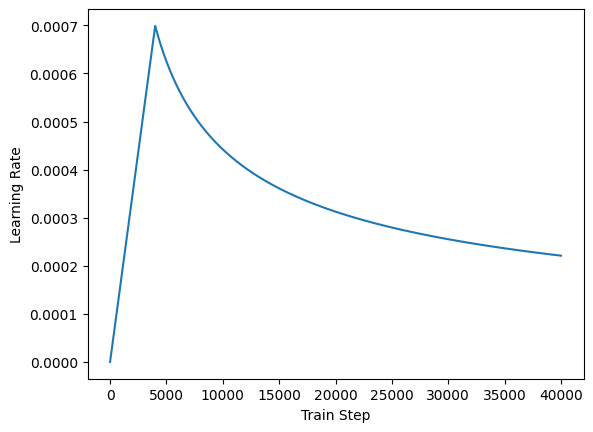

In [14]:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

### Set up the loss and metrics

Since the target sequences are padded, it is important to apply a padding mask when calculating the loss. Use the cross-entropy loss function (`tf.keras.losses.SparseCategoricalCrossentropy`):

In [15]:
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss


def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0

  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)

### Train the model

With all the components ready, configure the training procedure using `model.compile`, and then run it with `model.fit`:

Note: This takes about an hour to train in Colab.

In [16]:
transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

In [17]:
transformer.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds)

Epoch 1/25
89/89 [==============================] - 64s 408ms/step - loss: 7.6843 - masked_accuracy: 0.0695 - val_loss: 6.8700 - val_masked_accuracy: 0.1388
Epoch 2/25
89/89 [==============================] - 30s 335ms/step - loss: 6.3176 - masked_accuracy: 0.1818 - val_loss: 5.6168 - val_masked_accuracy: 0.2217
Epoch 3/25
89/89 [==============================] - 29s 329ms/step - loss: 5.2496 - masked_accuracy: 0.2591 - val_loss: 4.7051 - val_masked_accuracy: 0.3061
Epoch 4/25
89/89 [==============================] - 30s 332ms/step - loss: 4.5186 - masked_accuracy: 0.3297 - val_loss: 4.1158 - val_masked_accuracy: 0.3639
Epoch 5/25
89/89 [==============================] - 28s 314ms/step - loss: 3.9919 - masked_accuracy: 0.3867 - val_loss: 3.6831 - val_masked_accuracy: 0.4192
Epoch 6/25
89/89 [==============================] - 29s 321ms/step - loss: 3.5616 - masked_accuracy: 0.4352 - val_loss: 3.3475 - val_masked_accuracy: 0.4577
Epoch 7/25
89/89 [==============================] - 29s 32

In [18]:
transformer.summary() # 9 Million Parameter Model

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  65579008  
                                                                 
 decoder (Decoder)           multiple                  115993600 
                                                                 
 dense_24 (Dense)            multiple                  2565000   
                                                                 
Total params: 184,137,608
Trainable params: 184,137,608
Non-trainable params: 0
_________________________________________________________________


## Run inference

You can now test the model by performing a translation. The following steps are used for inference:

* Encode the input sentence using the tokenizer. This is the encoder input.
* The decoder input is initialized to the `[START]` token.
* Calculate the padding masks and the look ahead masks.
* The `decoder` then outputs the predictions by looking at the `encoder output` and its own output (self-attention).
* Concatenate the predicted token to the decoder input and pass it to the decoder.
* In this approach, the decoder predicts the next token based on the previous tokens it predicted.

Note: The model is optimized for _efficient training_ and makes a next-token prediction for each token in the output simultaneously. This is redundant during inference, and only the last prediction is used.  This model can be made more efficient for inference if you only calculate the last prediction when running in inference mode (`training=False`).

Define the `QuestionAnswering` class by subclassing `tf.Module`:

In [36]:
vocab = text_processor.get_vocabulary()

In [37]:
MAX_TOKENS = 256

class QuestionAnswering(tf.Module):
  def __init__(self, tokenizers, transformer):
    self.tokenizers = tokenizers
    self.transformer = transformer

  def __call__(self, sentence, max_length=MAX_TOKENS):
    # The input sentence is Portuguese, hence adding the `[START]` and `[END]` tokens.
    sentence = tf.convert_to_tensor([sentence])

    assert isinstance(sentence, tf.Tensor)
    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]

    # sentence = self.tokenizers.pt.tokenize(sentence).to_tensor()
    sentence = self.tokenizers(sentence).to_tensor()

    encoder_input = sentence

    # As the output language is English, initialize the output with the
    # English `[START]` token.
    start_end = self.tokenizers([''])[0]
    start = start_end[0][tf.newaxis]
    end = start_end[1][tf.newaxis]

    # `tf.TensorArray` is required here (instead of a Python list), so that the
    # dynamic-loop can be traced by `tf.function`.
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())
      predictions = self.transformer([encoder_input, output], training=False)

      # Select the last token from the `seq_len` dimension.
      predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.

      predicted_id = tf.argmax(predictions, axis=-1)

      # Concatenate the `predicted_id` to the output which is given to the
      # decoder as its input.
      output_array = output_array.write(i+1, predicted_id[0])

      if predicted_id == end:
        break

    output = tf.transpose(output_array.stack())
    vocab_tf = tf.constant(vocab)

    text = tf.strings.reduce_join(tf.map_fn(lambda x: vocab_tf[x], tf.squeeze(output), dtype=tf.string), separator=" ")
    tokens = output

    # `tf.function` prevents us from using the attention_weights that were
    # calculated on the last iteration of the loop.
    # So, recalculate them outside the loop.
    self.transformer([encoder_input, output[:,:-1]], training=False)
    attention_weights = self.transformer.decoder.last_attn_scores

    return text, tokens, attention_weights

Note: This function uses an unrolled loop, not a dynamic loop. It generates `MAX_TOKENS` on every call. Refer to the [NMT with attention](nmt_with_attention.ipynb) tutorial for an example implementation with a dynamic loop, which can be much more efficient.

Create an instance of this `Translator` class, and try it out a few times:

In [38]:
questionAnswerer = QuestionAnswering(text_processor, transformer)

In [39]:
import re

# Formatting for responses
def format_output(sentence):
    # Strip spaces around punctuation
    sentence = re.sub(r'\s+([.,!?])', r'\1', str(sentence.numpy()))

    # Capitalize known proper nouns
    known_proper_nouns = {"suny": "SUNY", "brockport": "Brockport", "computer": "Computer", "science": "Science"}
    for key, value in known_proper_nouns.items():
        sentence = sentence.replace(key, value)

    # Capitalize the first letter of the sentence
    sentence = sentence[0].upper() + sentence[1:]

    return sentence

# Print it out nicely
def print_translation(sentence, translated_text):
  print(f'Input: {sentence}')
  print(f'Prediction: {translated_text}')

In [40]:
sentence = 'How many programs does Brockport offer?'

translated_text, tokens, attention_weights = questionAnswerer(sentence)
print_translation(sentence, translated_text)

Input: How many programs does Brockport offer?
Prediction: b'[START] brockport offers over minors . [END]'


In [41]:
sentence = 'Are SAT scores required?'

translated_text, tokens, attention_weights = questionAnswerer(tf.constant(sentence))
print_translation(sentence, translated_text)

Input: Are SAT scores required?
Prediction: b'[START] no , optional scores are not typically not acceptable and sat or act scores . [END]'


In [42]:
sentence = 'How can I apply for financial aid?'

translated_text, tokens, attention_weights = questionAnswerer(tf.constant(sentence))
print_translation(sentence, translated_text)

Input: How can I apply for financial aid?
Prediction: b'[START] you can apply for financial aid through the financial aid office . [END]'


In [43]:
sentence = 'What concentrations are available for Computer Science?'

translated_text, tokens, attention_weights = questionAnswerer(tf.constant(sentence))
print_translation(sentence, translated_text)

Input: What concentrations are available for Computer Science?
Prediction: b'[START] computer science systems [UNK] are available for computer science , such as computer information systems , science , and the computer information systems . [END]'


In [44]:
sentence = "What limitations are there for non-matriculated students if they choose to enroll at a later date?"

translated_text, tokens, attention_weights = questionAnswerer(tf.constant(sentence))
print_translation(sentence, translated_text)

Input: What limitations are there for non-matriculated students if they choose to enroll at a later date?
Prediction: b'[START] nonmatriculated students choose to enroll at a later date , they are subject to all changes in the course catalog . [END]'


## Export the model

You have tested the model and the inference is working. Next, you can export it as a `tf.saved_model`. To learn about saving and loading a model in the SavedModel format, use [this guide](https://www.tensorflow.org/guide/saved_model).

Create a class called `ExportTranslator` by subclassing the `tf.Module` subclass with a `tf.function` on the `__call__` method:

In [45]:
class ExportTranslator(tf.Module):
  def __init__(self, translator):
    self.translator = translator

  @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
  def __call__(self, sentence):
    # sentence = tf.constant([sentence])
    result, tokens, attention_weights = self.translator(sentence, max_length=MAX_TOKENS)

    return result

In the above `tf.function` only the output sentence is returned. Thanks to the [non-strict execution](https://tensorflow.org/guide/intro_to_graphs) in `tf.function` any unnecessary values are never computed.

Wrap `translator` in the newly created `ExportTranslator`:

In [46]:
questionAnswerer = ExportTranslator(questionAnswerer)

# Note to self:

Need to figure out what's causing this error and fix it. Then I can save the model and load it in any other notebook.

In [47]:
questionAnswerer('How can I apply?').numpy()

Instructions for updating:
Use fn_output_signature instead


Instructions for updating:
Use fn_output_signature instead


b'[START] you can apply to suny brockport by visiting their website and filling out the application . [END]'

In [ ]:
tf.saved_model.save(questionAnswerer, export_dir=save_dir)

# Test loading in the model now

In [49]:
model = tf.saved_model.load('./models/transformer_v2')
model("How can I apply?").numpy()

b'[START] you can apply to suny brockport by visiting their website and filling out the application . [END]'